In [1]:
### Loading the libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import KFold
from functools import reduce
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

from matplotlib import pyplot as plt


In [4]:
#Loading data
dem = pd.read_excel('DMML_Project_Dataset.xlsx', sheet_name='Soc_Dem')
balance = pd.read_excel('DMML_Project_Dataset.xlsx', sheet_name='Products_ActBalance')
flow = pd.read_excel('DMML_Project_Dataset.xlsx', sheet_name='Inflow_Outflow')
revenue = pd.read_excel('DMML_Project_Dataset.xlsx', sheet_name='Sales_Revenues')


dem, balance, flow and revenue dataframes contain demographics, product account balance, cash inflow outflow and revenue details. We will look at the sizes of the dataframes.

## Data Analysis

In [5]:
dem.shape

(1615, 4)

In [6]:
balance.shape

(1615, 13)

In [7]:
flow.shape

(1587, 15)

In [8]:
revenue.shape

(969, 7)

In [9]:
revenue.columns

Index(['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC',
       'Revenue_CL'],
      dtype='object')

Revenue contains only 60% of customer data. As part this project we need to predict values for 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC' and 'Revenue_CL'. Cash inflow, outflow dataset doesn't contain entried for few clients.

We will analyse the dataframes and see if there are any null values and determine whether to impute them.

In [10]:
#Checking for null values from demographics
dem.isnull().any()

Client    False
Sex        True
Age       False
Tenure    False
dtype: bool

In [11]:
dem[dem['Sex'].isnull() == True]

,Client,Sex,Age,Tenure
422,1363,NaN,38,8
1062,953,NaN,50,35
1494,843,NaN,36,151


There are only 3 NaN values, so it won't have a lot of impact if we just remove them. However we will remove them after combining data from all dataframes.

In [12]:
#Checking null values in Product_ActBalance data
balance.isnull().any()

Client        False
Count_CA      False
Count_SA       True
Count_MF       True
Count_OVD      True
Count_CC       True
Count_CL       True
ActBal_CA     False
ActBal_SA      True
ActBal_MF      True
ActBal_OVD     True
ActBal_CC      True
ActBal_CL      True
dtype: bool

In [13]:
balance.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


We can see that the blank cells from the excel sheet have transformed into NaN values after importing into pandas.
Blank values against the field means no value present for that category and since these are numbers, we can safety replace all NaN values with 0.

In [14]:
#Filling NA values with 0
balance = balance.fillna('0')

In [15]:
#Checking for null values from flow
flow.isnull().any()

Client                          False
VolumeCred                      False
VolumeCred_CA                   False
TransactionsCred                False
TransactionsCred_CA             False
VolumeDeb                       False
VolumeDeb_CA                    False
VolumeDebCash_Card              False
VolumeDebCashless_Card          False
VolumeDeb_PaymentOrder          False
TransactionsDeb                 False
TransactionsDeb_CA              False
TransactionsDebCash_Card        False
TransactionsDebCashless_Card    False
TransactionsDeb_PaymentOrder    False
dtype: bool

No NaN values

In [16]:
#Checking for null values from revenue
revenue.isnull().any()

Client        False
Sale_MF       False
Sale_CC       False
Sale_CL       False
Revenue_MF    False
Revenue_CC    False
Revenue_CL    False
dtype: bool

All good so far. Now it's time to join all the dataframes into one for easier analysis. We will use inner join based on "Client" which is the primary key.

In [17]:
#Joining the dataframes for all clients (except Sales_revenues)
df1 = pd.merge(dem, balance, on='Client', how='inner')
df = pd.merge(df1, flow, on='Client', how='inner')

In [18]:
df.shape

(1587, 30)

In [19]:
#Creating dataset with 60% clients' data
data = pd.merge(df, revenue, on='Client', how='inner')
data.isnull().any()

Client                          False
Sex                              True
Age                             False
Tenure                          False
Count_CA                        False
Count_SA                        False
Count_MF                        False
Count_OVD                       False
Count_CC                        False
Count_CL                        False
ActBal_CA                       False
ActBal_SA                       False
ActBal_MF                       False
ActBal_OVD                      False
ActBal_CC                       False
ActBal_CL                       False
VolumeCred                      False
VolumeCred_CA                   False
TransactionsCred                False
TransactionsCred_CA             False
VolumeDeb                       False
VolumeDeb_CA                    False
VolumeDebCash_Card              False
VolumeDebCashless_Card          False
VolumeDeb_PaymentOrder          False
TransactionsDeb                 False
Transactions

The NaN values in Sex is because of missing values in dem dataframe. Let's take a look at those 3 rows

In [20]:
data[data['Sex'].isnull() == True]

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
624,953,NaN,50,35,1,1,0,0,0,0,...,18,0,3,7,0,0,1,0.0,0.0,15.222143
880,843,NaN,36,151,1,0,0,0,0,0,...,23,1,8,11,0,0,0,0.0,0.0,0.000000


Out of the 3 missing rows we saw earlier, one got removed when we joined with the "flow" dataframe. We will remove these 2.

In [21]:
#Removing N/A values (which were created due to missing gender values in demographics)
data = data.dropna()

In [22]:
data.shape

(949, 36)

data is the main dataset we will be using for training our model as it contains values for Sales and Revenue details. We will form another dataset using the remaining 40% clients, which will be used for predicting Sales and Revenue details.

In [23]:
#Creating question dataset for the other 40% of clients
common = df1.merge(revenue, on='Client')
df2 = df1[(~df1.Client.isin(common.Client))]
questionData = pd.merge(df2, flow, on='Client', how='inner')

In [24]:
#Removing N/A values (which were created due to missing gender values in demographics)
questionData = questionData.dropna()

Since most machine learning algorithms work with numbers data, we will have to label-encode M and F values of Sex into numbers.

In [25]:
# Converting categorical variable to numerical
data["Sex"] = pd.Categorical(data["Sex"]).codes

In [26]:
data.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [27]:
data.describe()

,Client,Sex,Age,Tenure,Count_CA,ActBal_CA,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,...,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,815.430980,0.533193,42.928346,100.305585,1.076923,2501.271078,1833.102737,1482.140850,5.654373,4.297155,...,13.807165,2.022129,5.360379,4.620653,0.203372,0.249737,0.303477,1.965585,2.742972,3.643327
std,465.853489,0.499160,18.647834,65.690566,0.327026,6291.004325,6218.049899,4815.617980,6.411573,4.925414,...,13.012640,2.711620,8.384657,5.237547,0.402719,0.433089,0.460002,10.043971,17.874145,7.782232
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,422.000000,0.000000,29.000000,42.000000,1.000000,73.135000,269.107857,229.476071,2.000000,2.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,815.000000,1.000000,41.000000,94.000000,1.000000,536.951429,657.161429,632.144286,4.000000,3.000000,...,11.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1220.000000,1.000000,58.000000,151.000000,1.000000,2278.614643,1449.070714,1317.101429,6.000000,4.000000,...,19.000000,3.000000,7.000000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.852143
max,1615.000000,1.000000,90.000000,271.000000,4.000000,74934.956071,107703.804286,98717.675000,63.000000,48.000000,...,83.000000,25.000000,60.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


In [28]:
# Converting categorical variable to numerical for question dataset
questionData["Sex"] = pd.Categorical(questionData["Sex"]).codes

In [134]:
questionData.describe()

,Sex,Age,Tenure,Count_CA,ActBal_CA,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,...,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,...,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,19.000000,31.000000,194.000000
mean,0.527559,42.541732,102.815748,1.080315,2379.911374,1813.139445,1544.821483,5.385827,4.223622,1688.804965,...,1.944882,5.067717,4.565354,796.173228,0.029921,0.048819,0.305512,10.038920,7.736919,14.194553
std,0.499633,18.569065,64.092370,0.339102,8201.260693,5312.602176,4435.837521,6.284083,4.985190,5916.035424,...,2.715498,8.407981,5.178218,468.746706,0.170504,0.215659,0.460987,2.225250,3.168667,1.990688
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,5.844206,3.985214,10.484491
25%,0.000000,29.000000,45.500000,1.000000,44.503036,225.194107,199.822321,2.000000,2.000000,213.567857,...,0.000000,0.000000,0.000000,377.000000,0.000000,0.000000,0.000000,8.235607,5.221819,12.921767
50%,1.000000,40.000000,102.000000,1.000000,355.584286,647.254286,601.965000,3.000000,3.000000,607.821429,...,1.000000,1.000000,3.000000,791.000000,0.000000,0.000000,0.000000,10.650458,7.321612,13.753582
75%,1.000000,56.500000,152.000000,1.000000,1961.592500,1384.588393,1284.275357,6.000000,5.000000,1371.164286,...,3.000000,7.000000,7.000000,1197.000000,0.000000,0.000000,1.000000,12.201128,8.608332,15.182094
max,1.000000,97.000000,273.000000,4.000000,171575.889643,90124.609643,68667.552500,56.000000,37.000000,119906.503929,...,17.000000,48.000000,31.000000,1614.000000,1.000000,1.000000,1.000000,13.276423,17.652752,22.497185


## Data Visualisation

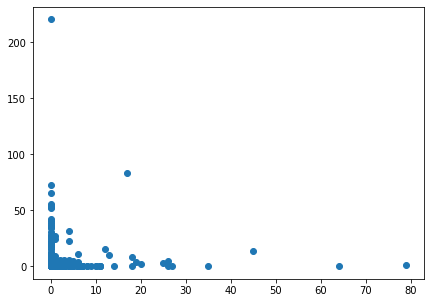

In [30]:
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize = (7,5))

x_axis = data['Count_MF'].astype('int64').values
y_axis = data['Revenue_MF'].values

# create
plt.scatter(x_axis, y_axis)

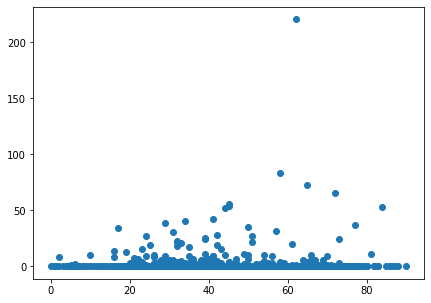

In [31]:
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize = (7,5))

x_axis = data['Age'].values
y_axis = data['Revenue_MF'].values

# create
plt.scatter(x_axis, y_axis)

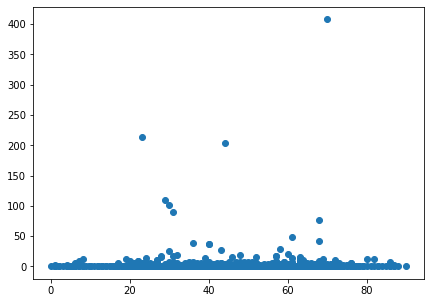

In [32]:
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize = (7,5))

x_axis = data['Age'].values
y_axis = data['Revenue_CC'].values

# create
plt.scatter(x_axis, y_axis)

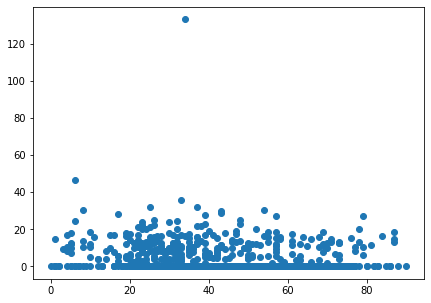

In [33]:
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize = (7,5))

x_axis = data['Age'].values
y_axis = data['Revenue_CL'].values

# create
plt.scatter(x_axis, y_axis)

### Detect Outliers

Let's look at boxplots for Revenue_MF, Revenue_CC and Revenue_CL to confirm presence of outliers

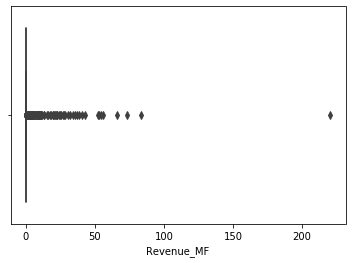

In [35]:
import seaborn as sns
sns.boxplot(data['Revenue_MF'])

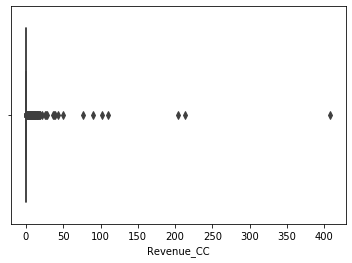

In [36]:
sns.boxplot(data['Revenue_CC'])

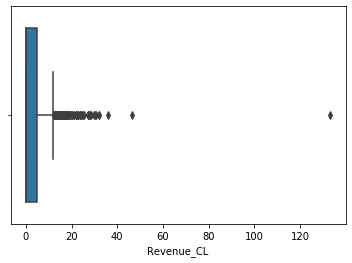

In [37]:
sns.boxplot(data['Revenue_CL'])

As the outliers look quite far from the rest of the data, presence of these outliers can really affect the data distribution. So we will remove them.

In [38]:
#Let's remove the 3 outliers
data = data[data['Revenue_MF'] < 200]
data = data[data['Revenue_CC'] < 400]
data = data[data['Revenue_CC'] < 120]

### Pre-processing before applying ML algorithms


Now that the dataset is ready, we can do the pre-processing and start building our machine algorithms to fit the dataset.

In [39]:
data.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [40]:
#Declare columns to be used as features
features = [
       'Age', 'Sex', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

In [41]:
# Declare columns to be used as targets
target = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']

In [42]:
# Predictor dataset
X = data[features]

In [43]:
# Target dataset 
y_target = data[['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']]

## Applying machine learning agorithms


We have 6 predictors to predict : 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'.
'Sale_MF', 'Sale_CC' and 'Sale_CL' are categorical variables while 'Revenue_MF', 'Revenue_CC' and 'Revenue_CL' are regression variables. To keep it simple we will build different models for each of them.

#### Predicting Sale_MF


In [44]:
# Target variable
y = y_target['Sale_MF']

In [45]:
# Randomforest model
Sale_MF_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=1, n_jobs=-1)

In [46]:
# We will create a function to calculate average of a list
def Average(lst): 
    return reduce(lambda a, b: a + b, lst) / len(lst)

In [47]:
# kfold cross-validation to determine accuracy
scores_MF = []

cv = KFold(n_splits=5, random_state=3, shuffle=True)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    Sale_MF_model.fit(X_train, y_train)
    scores_MF.append(Sale_MF_model.score(X_test, y_test))
    
# Model score
print(scores_MF)
Average(scores_MF)

[0.8253968253968254, 0.8042328042328042, 0.7936507936507936, 0.8359788359788359, 0.7724867724867724]


0.8063492063492064

The model score suggests that the accuracy looks pretty good. Let's look at cross_val_score

In [48]:
# Cross validation score
scores_MF = cross_val_score(Sale_MF_model, X, y, cv=5)
scores_MF.mean()

0.7968119471254969

The accuracy scores all look good, this means the model is a good fit for our data. We will use "Sale_MF_model" to calculate the value for "Sale_MF". Let's move on to other variables.

#### Predicting Sale_CC

In [49]:
# Target variable
y = y_target['Sale_CC']

In [50]:
# Randomforest
Sale_CC_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=1, n_jobs=-1)

In [52]:
# kfold cross-validation to determine accuracy
scores_CC = []

for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    Sale_CC_model.fit(X_train, y_train)
    scores_CC.append(Sale_CC_model.score(X_test, y_test))

# Model score
print(scores_MF)
Average(scores_MF) 

[0.80526316 0.8042328  0.79365079 0.78835979 0.79255319]


0.7968119471254969

In [53]:
# Cross validation score
scores_CC = cross_val_score(Sale_CC_model, X, y, cv=5)
scores_MF.mean()

0.7968119471254969

Since accuracy is close to 80%, we will use "Sale_CC_model" to calculate the value for "Sale_CC"

#### Predicting Sale_CL

In [54]:
#Setting target variable
y = y_target['Sale_CL']

In [55]:
# Testing algorithm for 'Sale_CL'
Sale_CL_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=1, n_jobs=-1)

In [56]:
# kfold cross-validation to determine accuracy
scores_CL = []

for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    Sale_CL_model.fit(X_train, y_train)
    scores_CL.append(Sale_CL_model.score(X_test, y_test))

# Model score
print(scores_CL)
Average(scores_CL) 

[0.7619047619047619, 0.7195767195767195, 0.7195767195767195, 0.6455026455026455, 0.6984126984126984]


0.7089947089947091

In [57]:
# Cross validation score
scores_CL = cross_val_score(Sale_CL_model, X, y, cv=5)
scores_CL.mean()

0.7068829283610918

The accuracy though not great We will use "Sale_CL_model" to calculate the value for "Sale_CL"

#### Predicting Revenue_MF

First we will filter all clients having Sale_MF = 1 in the train dataset and use Machine Learning to calculate Revenue_MF for those clients only. Because Revenue_MF is 0 when Sale_MF is 0. So no point including these rows for training our model.

In [59]:
data_Revenue_MF = data[data['Sale_MF']==1]
data_Revenue_MF.shape

(191, 36)

In [60]:
# Predictor and target variables
X_MF = data_Revenue_MF[features]
y_MF = data_Revenue_MF[target]['Revenue_MF']

In [61]:
#Split data into training, validation and test datasets (60:20:20)
X_MF_train, X_MF_test, y_MF_train, y_MF_test = train_test_split(X_MF, y_MF, test_size=0.2, random_state=1)

#Split train data into train and validation datasets
X_MF_train, X_MF_validation, y_MF_train, y_MF_validation = train_test_split(X_MF_train, y_MF_train, test_size=0.25, random_state=1)

In [63]:
# Testing RandomForest algorithm for 'Revenue_MF' with default values
revenue_MF_rf = RandomForestRegressor(random_state=1)
revenue_MF_rf.fit(X_MF_train, y_MF_train)


/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [64]:
prediction_Revenue_MF = revenue_MF_rf.predict(X_MF_validation)

RMSE = sqrt(mean_squared_error(y_true = y_MF_validation, y_pred = prediction_Revenue_MF))
RMSE

16.75769738046921

RMSE value is high. Let's see if we can make it better by fine-tuning by using RandomizedSearchCV. To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [65]:
#####Random Hyperparameter Grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 35, 61, 87, 113, 138, 164, 190, 216, 242, 267, 293, 319, 345, 371, 396, 422, 448, 474, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings. However, the benefit of a random search is that the model will try only a randomly selected sample from a wide range of values. Now, we instantiate the random search and fit it.

In [66]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = revenue_MF_rf, param_distributions = random_grid, n_iter = 50, 
                               cv = 5, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_MF_train, y_MF_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   20.2s finished
/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=1...


We can view the best parameters from fitting the random search

In [67]:
rf_random.best_params_

{'n_estimators': 448,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

From these results, we should be able to narrow the range of values for each hyperparameter.

In [68]:
#Model fitting
revenue_MF_model = rf_random.best_estimator_
revenue_MF_model.fit(X_MF_train, y_MF_train)

#Prediction on validation set
prediction_Revenue_MF = revenue_MF_model.predict(X_MF_validation)

#Calculating root-mean-square for the predicted data
RMSE = sqrt(mean_squared_error(y_true = y_MF_validation, y_pred = prediction_Revenue_MF))
RMSE

14.248118649847033

In [69]:
#Prediction on final test set
prediction_Revenue_MF = revenue_MF_model.predict(X_MF_test)

#Calculating root-mean-square for the predicted data
RMSE = sqrt(mean_squared_error(y_true = y_MF_test, y_pred = prediction_Revenue_MF))
RMSE

9.312564706946961

RMSE values look much better after fine-tuning. We can use the model "revenue_MF" to calculate Revenue_MF values. We will perform similar fine-tuning for Revenue_CC and Revenue_CL.

#### Predicting Revenue_CC

In [70]:
data_Revenue_CC = data[data['Sale_CC']==1]

In [71]:
data_Revenue_CC.shape

(234, 36)

In [72]:
X_CC = data_Revenue_CC[features]
y_CC = data_Revenue_CC[target]['Revenue_CC']

In [73]:
# Testing algorithm for 'Revenue_CC'
revenue_CC_rf = RandomForestRegressor(random_state=100)

In [74]:
#Split data into training, validation and test datasets (60:20:20)
X_CC_train, X_CC_test, y_CC_train, y_CC_test = train_test_split(X_CC, y_CC, test_size=0.2, random_state=1)

#Split train data into train and validation datasets
X_CC_train, X_CC_validation, y_CC_train, y_CC_validation = train_test_split(X_CC_train, y_CC_train, test_size=0.25, random_state=1)

In [75]:
# Testing RandomForest algorithm for 'Revenue_MF' with default values
revenue_CC_rf = RandomForestRegressor()
revenue_CC_rf.fit(X_CC_train, y_CC_train)

/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [76]:
#Calculating root-mean-square error with default values on validation dataset
prediction_Revenue_CC = revenue_CC_rf.predict(X_CC_validation)

RMSE = sqrt(mean_squared_error(y_true = y_CC_validation, y_pred = prediction_Revenue_CC))
RMSE

12.647565531855435

In [77]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_CC = RandomizedSearchCV(estimator = revenue_CC_rf, param_distributions = random_grid, n_iter = 50, 
                               cv = 5, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_CC.fit(X_CC_train, y_CC_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   20.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=N...


In [78]:
rf_CC.best_params_

{'n_estimators': 448,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [79]:
# RMSE on validation dataset
revenue_CC_model = rf_CC.best_estimator_
revenue_CC_model.fit(X_CC_train, y_CC_train)

prediction_Revenue_CC = revenue_CC_model.predict(X_CC_validation)

RMSE = sqrt(mean_squared_error(y_true = y_CC_validation, y_pred = prediction_Revenue_CC))
RMSE

11.892122964572813

In [80]:
#Prediction on final test set
prediction_Revenue_CC = revenue_CC_model.predict(X_CC_test)

#Calculating root-mean-square for the predicted data
RMSE = sqrt(mean_squared_error(y_true = y_CC_test, y_pred = prediction_Revenue_CC))
RMSE

9.936478009880965

The model accuracy looks better, so we will be considering this for our prediction of "Revenue_CC" values.

#### Predicting Revenue_CL

In [81]:
#Filtering Sale_CL data
data_Revenue_CL = data[data['Sale_CL']==1]

In [82]:
data_Revenue_CL.shape

(287, 36)

In [83]:
#Predictor and target datasets
X_CL = data_Revenue_CL[features]
y_CL = data_Revenue_CL[target]['Revenue_CL']

In [84]:
#Split data into training and test datasets (60:20:20)
X_CL_train, X_CL_test, y_CL_train, y_CL_test = train_test_split(X_CL, y_CL, test_size=0.2, random_state=1)

#Split train data into train and validation datasets
X_CL_train, X_CL_validation, y_CL_train, y_CL_validation = train_test_split(X_CL_train, y_CL_train, test_size=0.25, random_state=1)

In [85]:
# Testing RandomForest algorithm for 'Revenue_CL' with default values
revenue_CL_rf = RandomForestRegressor()
revenue_CL_rf.fit(X_CL_train, y_CL_train)

/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [86]:
#RMSE on validation dadaset with default parameters
prediction_Revenue_CL = revenue_CL_rf.predict(X_CL_validation)

RMSE = sqrt(mean_squared_error(y_true = y_CL_validation, y_pred = prediction_Revenue_CL))
RMSE

17.38884939688646

In [87]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_CL = RandomizedSearchCV(estimator = revenue_CL_rf, param_distributions = random_grid, n_iter = 50, 
                               cv = 5, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_CL.fit(X_CL_train, y_CL_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.1s finished
/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=N...


In [88]:
rf_CL.best_params_

{'n_estimators': 448,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [89]:
#RMSE on validation dataset
revenue_CL_model = rf_CL.best_estimator_
revenue_CL_model.fit(X_CL_train, y_CL_train)

prediction_Revenue_CL = revenue_CL_model.predict(X_CL_validation)

RMSE = sqrt(mean_squared_error(y_true = y_CL_validation, y_pred = prediction_Revenue_CL))
RMSE

17.182345703759715

In [90]:
#RMSE on test test dataset
prediction_Revenue_CL = revenue_CL_model.predict(X_CL_test)

RMSE = sqrt(mean_squared_error(y_true = y_CL_test, y_pred = prediction_Revenue_CL))
RMSE

7.620115998227185

Now that we have all the machine learning models ready we will use them to answer the questions using our questData dataframe.

## Answering questions

We are trying to answer the following questions:
1. Which clients are to be targeted with which offer?
2. What would be the expected revenue based on your strategy?

We did not include 'Client' in our prediction. So we will have to remove from questionData before applying the machine learning algorithm and keep it separate. We will then attach it once prediction is done.

In [91]:
Clients = questionData['Client']

In [92]:
questionData = questionData.drop(['Client'], axis=1)
questionData.shape

(635, 29)

#### Predicting classification variables (sales variables)

In [93]:
Sale_MF = Sale_MF_model.predict(questionData)
Sale_CC = Sale_CC_model.predict(questionData)
Sale_CL = Sale_CL_model.predict(questionData)

In [94]:
#Attaching the Clients column again
questionData['Client'] = Clients

In [95]:
questionData.shape

(635, 30)

We will attach the predicted values with the actual questionData dataset

In [96]:
questionData['Sale_MF'] = Sale_MF
questionData['Sale_CC'] = Sale_CC
questionData['Sale_CL'] = Sale_CL

questionData.shape

(635, 33)

#### Predicting revenue values

We had built our regression models for calculating revenue variables by filtering out Sale variables. So we will calculate Revenue_MF for values where Sale_MF = 1. We will first filter out the data.

In [99]:
#Filtering data where Sale_MF is 1
question_mf = questionData[questionData['Sale_MF']==1]

In [100]:
#copying client column and keeping it separate
client_mf = question_mf['Client']

In [101]:
#Removing Client, Sale_MF, Sale_CC and Sale_CL variables before applying ML algorithm
question_mf = question_mf.iloc[:,:-4]

In [102]:
#Prediction
Revenue_MF = revenue_MF_model.predict(question_mf)

In [103]:
#Attaching client and predicted values to the dataset
question_mf['Client'] = client_mf
question_mf['Revenue_MF'] = Revenue_MF

In [104]:
# Storing Client and revenue details for further use
tmp1 = question_mf[['Client','Revenue_MF']]

#### Calculating Revenue_CC and Revenue_CC in the similar way

In [105]:
question_cc = questionData[questionData['Sale_CC']==1]

In [106]:
client_cc = question_cc['Client']

In [107]:
question_cc = question_cc.iloc[:,:-4]

In [108]:
question_cc.shape

(31, 29)

In [109]:
Revenue_cc = revenue_CC_model.predict(question_cc)

In [110]:
question_cc['Client'] = client_cc
question_cc['Revenue_CC'] = Revenue_cc

In [111]:
tmp2 = question_cc[['Client','Revenue_CC']]

In [112]:
# Calculating Revenue_CL
question_cl = questionData[questionData['Sale_CL']==1]
client_cl = question_cl['Client']
question_cl = question_cl.iloc[:,:-4]

#Prediction
Revenue_CL = revenue_CL_model.predict(question_cl)

#Attaching Client and predicted values
question_cl['Client'] = client_cl
question_cl['Revenue_CL'] = Revenue_CL

In [113]:
tmp3 = question_cl[['Client','Revenue_CL']]

In [114]:
tmp1.shape

(19, 2)

In [115]:
tmp2.shape

(31, 2)

In [116]:
tmp3.shape

(194, 2)

In [117]:
# Joining tmp1,tmp2 and tmp3 data with the questionData
questionData = pd.merge(questionData, tmp1, on='Client', how='left')

In [118]:
questionData = pd.merge(questionData, tmp2, on='Client', how='left')
questionData.shape

(635, 35)

In [119]:
questionData = pd.merge(questionData, tmp3, on='Client', how='left')
questionData.shape

(635, 36)

This is the final dataset which contains 40% of customer data alongwith all the predicted values. We will export this dataset at the end of the markdown.

To answer the questions mentioned above, we only need Client data and revenue details, which are collected in tmp1, tmp2 and tmp3. We will combine all the 3 dataframes to collect data for all clients having either of the 3 types of revenue. To do this, our approach is:
1. convert Revenue_MF, Revenue_CC and Revenue_CL to a common variable : revenue
2. Create a new variable depicting the type of offer (MF, CL, CC)
3. Filter the top 100 revenues

In [120]:
tmp1.loc[:,'Type'] = "MF"
tmp1 = tmp1.rename(columns={"Revenue_MF": "revenue"})

/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/victordetraz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


We will perform similar modification for CC and CL

In [122]:
tmp2.loc[:,'Type'] = "CC"
tmp2 = tmp2.rename(columns={"Revenue_CC": "revenue"})

In [123]:
tmp3.loc[:,'Type'] = "Ctop_100 = final.nlargest(100,['revenue'])L"
tmp3=tmp3.rename(columns={"Revenue_CL": "revenue"})

In [124]:
final = tmp1.append(tmp2,sort=False)

In [125]:
final = final.append(tmp3,sort=False)

In [126]:
final.shape

(244, 3)

In [127]:
top_100 = final.nlargest(100,['revenue'])

In [128]:
sum(top_100.duplicated())

0

The above value is 0 which means there are no duplicates in the top 100 records.

We have got our clients who will be contacted for offers. The type of offer is mentioned in the column "Type".

Expected revenue based on the above prediction can be calculated as follows:

In [130]:
Total_expected_revenue = sum(top_100['revenue'])

In [131]:
Total_expected_revenue

1568.4733371692992

Let's export the data containing the list of top clients alongwith offer type to an excel sheet. We will also export the entire questionData to an excel sheet.

In [132]:
top_100.to_excel(excel_writer="top100Clients.xlsx")
questionData.to_excel(excel_writer="questionData.xlsx")